In [3]:
from desc import set_device
set_device("gpu")

/home/ye2698/DESC/desc/__init__.py:113: UserWarning: CUDA_VISIBLE_DEVICES= did not match any physical GPU (id=['0']), falling back to CPU
  warnings.warn(


In [4]:
from desc.examples import get
from desc.magnetic_fields import FourierCurrentPotentialField
from desc.grid import LinearGrid
from desc.derivatives import Derivative
from desc.backend import jnp
import numpy as np
from desc.io import load
import matplotlib.pyplot as plt
from desc.plotting import plot_2d, poincare_plot, plot_surfaces

DESC version 0.12.1+866.gd88602203,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 987.95 GB available memory


In [5]:
# eq = get("ESTELL")
eq = load("../SurfaceIntegral/isl_curr_dens_output.h5")
grid = LinearGrid(M=30,N=30,NFP=eq.NFP) # idk if sym=True is needed or not tbh so we will leave no sym here
data = eq.compute(["K_vc"],grid=grid)

/home/ye2698/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_rho' was not loaded from the file.
This is likely because the file containing 'FourierRZToroidalSurface' was created before '_rho' became an attribute of objects of class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'.
The user may verify that a default value has been set.
This warning will persist until the file is saved with the new object.

Note to developers: Add 'def _set_up(self)' as a method to class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'
(or the superclass where this new attribute is assigned) that assigns a value to '_rho'.
This method is called automatically when a file is loaded.
Recall that the testing suite will fail on warnings.
  warnings.warn(
/home/ye2698/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_shift' was not loaded from the file.
This is likely because the file containing 'FourierRZCurve' was created before '_shift' became an a

In [6]:
field = FourierCurrentPotentialField.from_surface(surface=eq.surface,M_Phi=20,N_Phi=20,sym_Phi=False)
def surf_curr(x):
    # x is [I,G,phi_mn]
    params = field.params_dict
    params["I"]=x[0]
    params["G"]=x[1]
    params["Phi_mn"]=x[2:]
    return field.compute("K",grid=grid,params=params)["K"].flatten(order="F")
# jacobian of the above fxn is the A s.t. Ax = K_field where K_field is the K of the FourierCurrentPotentialField
# since K is linear in x
A = Derivative(surf_curr)(jnp.zeros(field.Phi_mn.size+2))
# pseudoinvert Ax = K_vc to fit the field params to the virtual casing current
K_vc = data["K_vc"].flatten(order="F")
x = jnp.linalg.pinv(A) @ K_vc
field.I = x[0]
field.G = x[1]
field.Phi_mn = x[2:]

In [7]:
# plot_grid = LinearGrid(N=60,M=60,NFP=eq.NFP)
# plt.figure(figsize=(6,6))
# theta = plot_grid.nodes[:,1].reshape(plot_grid.num_zeta, plot_grid.num_theta)
# zeta = plot_grid.nodes[:,2].reshape(plot_grid.num_zeta, plot_grid.num_theta)
# data_eq = eq.compute("K_vc",grid=plot_grid)
# Kmag = jnp.linalg.norm(data_eq["K_vc"],axis=1)
# plt.contourf(zeta, theta, Kmag.reshape(plot_grid.num_zeta, plot_grid.num_theta),levels=50)
# plt.title("|K_vc|")
# plt.xlabel("zeta")
# plt.ylabel("theta")
# plt.colorbar()
# _,_,data_field=plot_2d(field,"K",grid=plot_grid,cmap="viridis",levels=50,figsize=(6,6),return_data=True)

In [8]:
# error_mag = abs(jnp.linalg.norm(data_eq["K_vc"],axis=1) - data_field["K"].flatten(order="F") )

# print(f"Max error: {jnp.max(error_mag)}")
# print(f"Min error: {jnp.min(error_mag)}")
# print(f"Avg error: {jnp.mean(error_mag)}\n")

# rel_error_mag = error_mag / jnp.linalg.norm(data["K_vc"])

# print(f"Max rel error: {jnp.max(rel_error_mag)}")
# print(f"Min rel error: {jnp.min(rel_error_mag)}")
# print(f"Avg rel error: {jnp.mean(rel_error_mag)}")


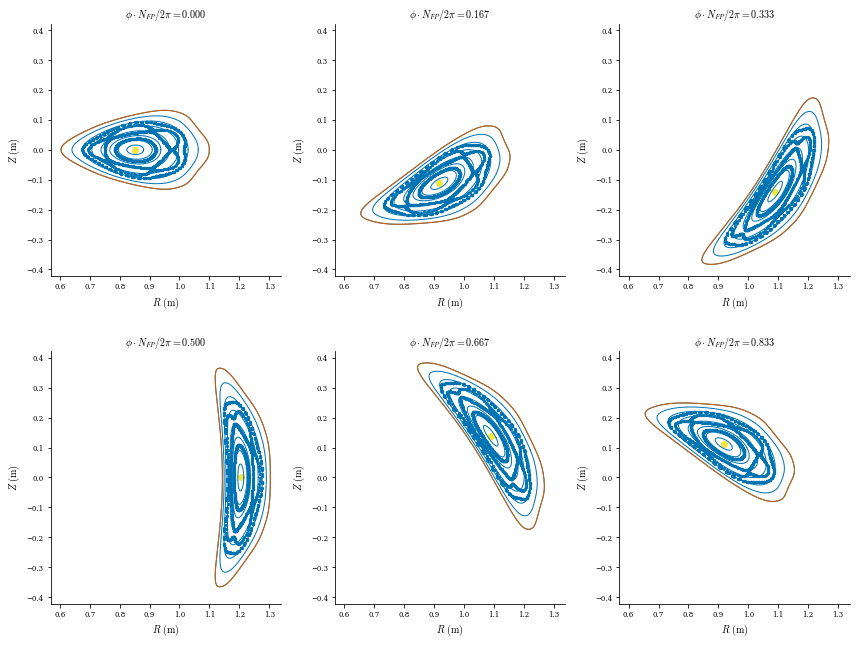

In [11]:
# takes a minute or two to run
grid = LinearGrid(rho=[0.3, 0.5, 0.5525, 0.7])
pos_data = eq.compute(["R","Z"],grid=grid)
fig,ax = plot_surfaces(eq,theta=0)
poincare_plot(field,R0=pos_data["R"],Z0=pos_data["Z"],ntransit=250,ax=ax);
plt.savefig("trace.png", dpi=300)

(<Figure size 288x288 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\frac{2\\pi}{\\mu_0} I ~(A)$'>)

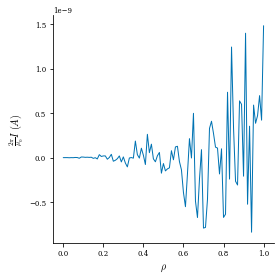

In [14]:
from desc.plotting import *
plot_1d(eq, "current")

In [19]:
from desc.objectives.getters import *
from desc.objectives import *
def solve_poincare(eq, fix_lambda=True, **kwargs):
    constraints = get_fixed_xsection_constraints(eq, fix_lambda=fix_lambda)
    objective = ObjectiveFunction(ForceBalance(eq))
    eq.solve(constraints=constraints, objective=objective, verbose=3, **kwargs)
    
def solve_fixed(eq, **kwargs):
    constraints = get_fixed_boundary_constraints(eq)
    objective = ObjectiveFunction(ForceBalance(eq))
    eq.solve(constraints=constraints, objective=objective, verbose=3, **kwargs)

In [ ]:
eq_poin = eq.copy()
solve_poincare(eq_poin, maxiter=300, ftol=1e-4)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.07 sec
Timer: Objective build = 1.48 sec
Building objective: poincare R
Building objective: poincare Z
Building objective: fixed Psi
Building objective: poincare Lambda
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency boundary R
Building objective: self_consistency boundary Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section Lambda
Timer: Objective build = 982 ms
Timer: Linear constraint projection build = 27.5 sec
Number of parameters: 7344
Number of objectives: 25650
Timer: Initializing the optimization = 30.2 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost

In [ ]:
plot_comparsion(eqs=[eq, eq_poin], labels=["original", "resolve poincare"])